In [60]:
from lifetimes.utils import summary_data_from_transaction_data
import pandas as pd
import numpy as np
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_probability_alive_matrix
from datetime import datetime
import os
import pickle
import dill
import argparse



In [8]:
trans_summary=pd.read_csv('transaction_summary.csv',index_col='user_id',usecols=['user_id','frequency','recency','T'])

In [10]:
trans_summary.describe()

,frequency,recency,T
count,148667.000000,148667.000000,148667.000000
mean,1.768927,103.946256,449.316405
std,5.453184,200.643809,274.814259
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,233.000000
50%,0.000000,0.000000,435.000000
75%,1.000000,115.000000,628.000000
max,274.000000,1597.000000,1613.000000


In [11]:
bgf=BetaGeoFitter(penalizer_coef=0.0)

In [12]:
bgf.fit(trans_summary['frequency'],trans_summary['recency'],trans_summary['T'])


<lifetimes.BetaGeoFitter: fitted with 148667 subjects, a: 0.61, alpha: 19.45, b: 2.08, r: 0.18>

In [13]:
client_palive=trans_summary.copy()

In [19]:
client_palive['Palive']=client_palive.apply(lambda row: bgf.conditional_probability_alive(row['frequency'],row['recency'],row['T']) if row['frequency']>0 else bgf.conditional_probability_alive(row['frequency']+1,row['recency']+1,row['T'])  , axis=1)

In [21]:
file_path='./client_palive.csv'
if os.path.exists(file_path):
    os.remove(file_path)
else:
    client_palive.to_csv(file_path)

In [57]:
def save_model(model):
    try:
        model_name=model.__class__.__name__
        save_path=model_name+'.pkl'
        #print(save_model)
        if os.path.exists(save_path):
            os.remove(save_path)
        output_file=open(save_path,'wb')
        dill.dump(model,output_file)
        output_file.close()
        print('{} saved successfully.'.format(model_name))

    except Exception as e:

        print('Error in model')
        print (e)


        
def load_model():
    try:
        model_name='BetaGeoFitter'
        load_path=model_name+'.pkl'
        infile=open(load_path,'rb')
        model=dill.load(infile)
        return model
    except Exception as e:
        print('Failled to load the model')
        print(e)
    
    

In [58]:
model=load_model()

In [61]:
parser=argparse.ArgumentParser()


In [ ]:
if __name__=='__main__':
    
    ## add parser
    parser=argparse.ArgumentParser()
    parser.add_argument('--loadmodel',action='store_true')
    parser.add_argument('--trainmodel',action='store_true')
    parser.add_argument('--predict',action='store_true')
    args=parser.parse_args()
    
    ##init value
    trans_summary=pd.read_csv('transaction_summary.csv',index_col='user_id',usecols=['user_id','frequency','recency','T'])
    if args.trainmodel:
        bgf=BetaGeoFitter(penalizer_coef=0.0)
        bgf.fit(trans_summary['frequency'],trans_summary['recency'],trans_summary['T'])
        save_model(bgf)
    if args.loadmodel:
        bgf=load_model()
    if args.predict:
        client_palive=trans_summary.copy()
        client_palive['palive']=client_palive.apply(lambda row: bgf.conditional_probability_alive(row['frequency'],row['recency'],row['T']) if row['frequency']>0 else bgf.conditional_probability_alive(row['frequency']+1,row['recency']+1,row['T'])  , axis=1)
        file_path='./client_palive.csv'
    if os.path.exists(file_path):
        os.remove(file_path)
    else:
        client_palive.to_csv(file_path)
            
    
    
    
    

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

In [85]:
client_palive=client_palive.set_index(np.arange(client_palive.shape[0]))
client_palive1=client_palive.copy()
client_palive.Palive=round(client_palive.Palive*100)

AttributeError: 'numpy.float64' object has no attribute 'rint'

/usr/local/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


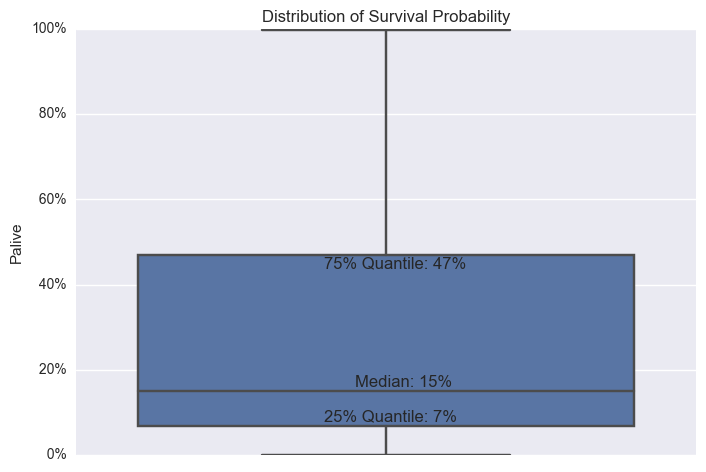

In [115]:
q_25=client_palive.Palive.quantile(0.25)
q_50=client_palive.Palive.quantile(0.50)
q_75=client_palive.Palive.quantile(0.75)


ax=sns.boxplot(y='Palive',data=client_palive1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])
plt.annotate('25% Quantile: '+str(round(q_25))+'%',xy=(0,q_25),xytext=(-0.10,q_25+1))
plt.annotate('Median: '+str(round(q_50))+'%',xy=(0,q_50),xytext=(-0.05,q_50+1))
plt.annotate('75% Quantile: '+str(round(q_75))+'%',xy=(0,q_75),xytext=(-0.10,q_75-3))
plt.title('Distribution of Survival Probability')
plt.ylim([0,100])
plt.show()

In [75]:
np.arange(client_palive.shape[0])

array([     0,      1,      2, ..., 148664, 148665, 148666])

In [89]:
client_palive.Palive.quantile(0.25)

6.900994122221727

In [124]:
client_rank=pd.read_csv('client_ranking.csv')

In [118]:
client_palive=pd.read_csv('client_palive.csv')

In [119]:
client_palive.head()

,user_id,frequency,recency,T,palive
0,109,274,1597,1609,0.983272
1,141,0,0,1183,0.025722
2,142,3,828,1617,0.450413
3,143,0,0,1588,0.018416
4,148,1,90,746,0.255356


In [126]:
client_set=client_palive.merge(client_rank,how='left',left_on='user_id',right_on='user_id')

In [127]:
client_set.to_csv('client_set.csv',index=False)